<a href="https://colab.research.google.com/github/AfrozSaqlain/Physics-Informed-Neural-Network/blob/main/Eigenvalue_problem_QHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
import torch.nn as nn

In [2]:
def quantum_harmonic_oscillator(n, x):
    """
    Quantum harmonic oscillator state function for n-th energy level.
    """
    m = 1
    omega = 1
    hbar = 1
    prefactor = ((m*omega)/(np.pi*hbar))**0.25
    normalization = 1 / np.sqrt(2**n * factorial(n))
    x_np = x.numpy()
    H_n = hermite(n)(np.sqrt(m*omega/hbar) * x_np)
    y_np = prefactor * normalization * H_n * np.exp(-m*omega*x_np**2 / (2*hbar))
    return torch.from_numpy(y_np).type_as(x)


class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    def __init__(self, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        self.activation = SineActivation()
        self.initial_layer = nn.Linear(1, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.energy = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, x):
        x = self.activation(self.initial_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

In [3]:
N_OUTPUT = 1
N_HIDDEN = 50
N_LAYERS = 3
model = FCN(N_OUTPUT, N_HIDDEN, N_LAYERS)


n = 13
x = torch.linspace(-12, 12, 10000).view(-1, 1)
y = quantum_harmonic_oscillator(n, x).view(-1, 1)


num_points = 40
x_data = torch.linspace(-7, 7, num_points).view(-1, 1)
y_data = quantum_harmonic_oscillator(n, x_data).view(-1, 1)


x_physics = torch.linspace(-12, 12, 50).view(-1,1).requires_grad_(True)

torch.manual_seed(123)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

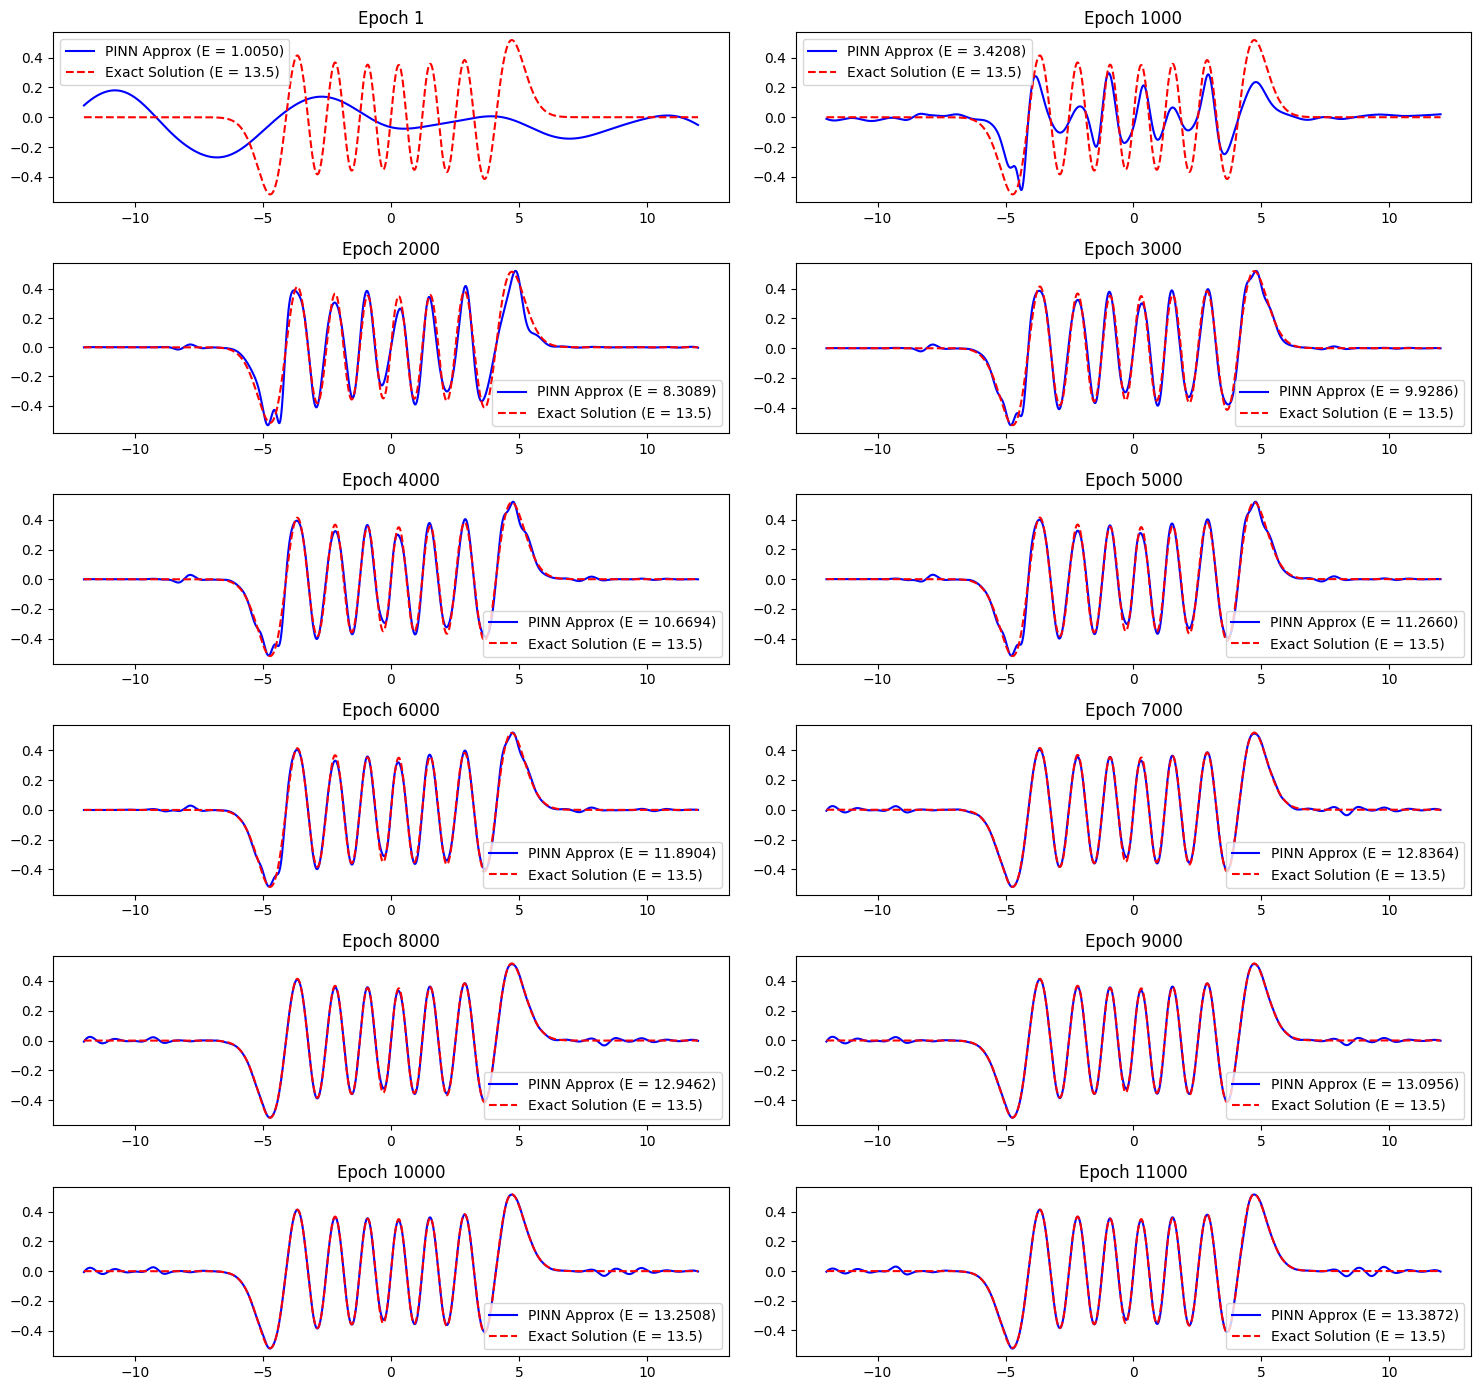

In [4]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15, 14))
ax = ax.flatten()

j = 0


for i in range(11000):
    optimizer.zero_grad()


    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)


    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
    physics = dx2 - (x_physics ** 2) * yhp + 2 * model.energy * yhp
    loss2 = 5e-3 * torch.mean(physics ** 2)

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()


    if  i == 0 or (i + 1) % 1000 == 0:
        with torch.inference_mode():
            yh_plot = model(x).detach()

        ax[j].plot(x, yh_plot, label=f'PINN Approx (E = {model.energy.item():.4f})', color='blue')
        ax[j].plot(x, y, linestyle='--', label=f'Exact Solution (E = {n + 0.5})', color='red')
        ax[j].set_title(f"Epoch {i + 1}")
        ax[j].legend()
        j += 1

plt.tight_layout()
plt.show()